In [2]:
#import library
from scipy.stats import norm
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_probability as tfp
from tensorflow_probability import edward2 as ed
tfd = tfp.distributions
import scipy.stats as st
from mpl_toolkits.mplot3d import Axes3D
import math

import seaborn as sns
import pandas as pd
%matplotlib inline

<b> Plot the true banana-shape distribution

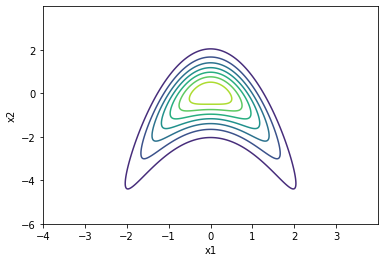

In [3]:
from scipy.stats import multivariate_normal

def plot_true():
    x, y = np.mgrid[-4:4:.01, -6:4:.01]
    pos = np.empty(x.shape + (2,)) 
    pos[:, :, 0] = x; pos[:, :, 1] = x**2+y
    rv = multivariate_normal([0, 0], [[1, 0], [0, 1]])
    plt.contour(x, y, rv.pdf(pos))
    plt.xlabel("x1")
    plt.ylabel("x2")
plot_true()

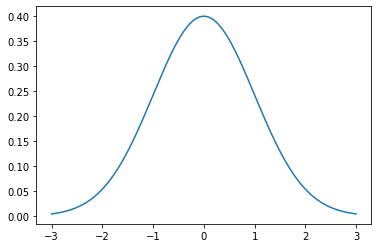

In [4]:
y = norm(0,1)
x = np.linspace(-3,3,1000)
plt.plot(x,y.pdf(x))

In [5]:
rv = multivariate_normal([0, 0], [[1, 0], [0, 1]])

inference of a multivariate normal distribution

In [6]:
## initial the model

# prior mean and covariance
mu= [0.,0.]

cov = [[ 10,  0.],
        [ 0.,  10]]

## pseudo observation 
c = [2,2] # mean of observations
N = 1000 # number of observation data
cov2y = [[ 10,  0.],
        [ 0.,  10]] # standard deviation of observation data

## generate the observation data
y_ = np.random.multivariate_normal(c, cov2y,N)
# y_ = np.random.normal(loc =c, scale = sigma2y, size = N)
D = tf.convert_to_tensor(y_,dtype = tf.float32)

## define the log probability
def joint_log_prob(D,theta1,theta2):
    
    # define random variables prior
    mvn = tfd.MultivariateNormalFullCovariance(
            loc = mu,
            covariance_matrix= cov)
    z = tf.stack([theta1, theta2], axis=-1)
    
    # define likelihood
    y = tfd.MultivariateNormalFullCovariance(
            loc = [theta1,theta2],
            covariance_matrix= cov)
#     y = tfd.Normal(loc = tf.add(theta2,theta1), scale = sigma2y)
    # return the posterior probability
#     return(mvn.log_prob(tf.squeeze(z))
#           +tf.reduce_sum(y.log_prob(tf.squeeze(z2))))
    return (mvn.log_prob(tf.squeeze(z))
            + tf.reduce_sum(y.log_prob(D)))

<b> Random walk Matropolis Hasting MCMC to explore the banana-shape distribution

In [15]:
num_results = 5000
burnin = 500

initial_chain_state = [
    0. * tf.ones([], dtype=tf.float32, name="init_t1"),
    0. * tf.ones([], dtype=tf.float32, name="init_t2")
]

dtype = np.float32

unnormalized_posterior_log_prob = lambda *args: joint_log_prob(D, *args)

def gauss_new_state_fn(scale, dtype):
  gauss = tfd.Normal(loc=dtype(0), scale=dtype(scale))
  def _fn(state_parts, seed):
    next_state_parts = []
    seed_stream  = tfp.util.SeedStream(seed, salt='RandomNormal')
    for sp in state_parts:
      next_state_parts.append(sp + gauss.sample(
        sample_shape=sp.shape, seed=seed_stream()))
    return next_state_parts
  return _fn

samples, kernel_results= tfp.mcmc.sample_chain(
    num_results=num_results,
    num_burnin_steps=burnin,
    current_state=initial_chain_state,
    kernel=tfp.mcmc.RandomWalkMetropolis(
        target_log_prob_fn=unnormalized_posterior_log_prob,
        new_state_fn=gauss_new_state_fn(scale=0.1, dtype=dtype),
        seed=42))  # For determinism.


samples = tf.stack(samples, axis=-1)
accepted = kernel_results.is_accepted

samples = samples.numpy()
accepted = accepted.numpy()

/Users/zhouji/.local/lib/python3.7/site-packages/tensorflow_probability/python/mcmc/sample.py:335: UserWarning: Tracing all kernel results by default is deprecated. Set the `trace_fn` argument to None (the future default value) or an explicit callback that traces the values you are interested in.
  warnings.warn("Tracing all kernel results by default is deprecated. Set "


In [16]:
x_samples,y_samples = samples[:,0],samples[:,1]

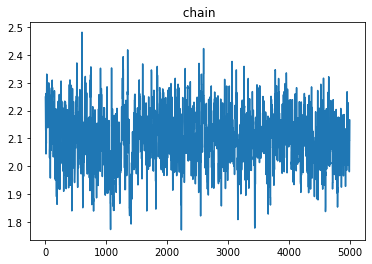

In [17]:
def chain_plot(data, title='', ax=None):
    '''Plot both chain and posterior distribution'''
    if ax is None:
        ax = plt.gca()
    ax.plot(data)
    ax.title.set_text(title+" chain")
    
def post_plot(data, title='', ax=None, true=None, prc=95):
  '''Plot the posterior distribution given MCMC samples'''
  if ax is None:
    ax = plt.gca()
  sns.kdeplot(data, ax=ax, shade=True)
  tprc = (100-prc)/2
  
  ax.axvline(x=np.percentile(data, tprc), linestyle='--')
  ax.axvline(x=np.percentile(data, 100-tprc), linestyle='--')
  ax.title.set_text(title+" distribution")
  if true is not None:
    ax.axvline(x=true)
    
chain_plot(x_samples)


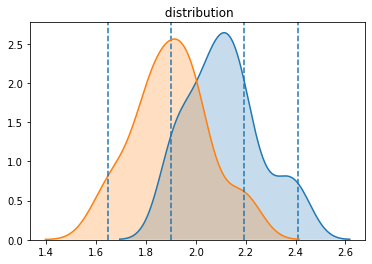

In [18]:
post_plot(x_accepted)
post_plot(y_accepted)

Acceptance rate: 55.1%


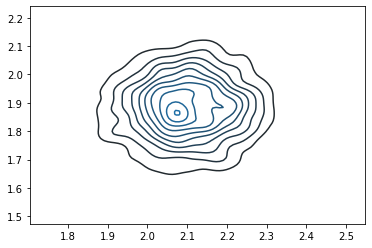

In [19]:
##plot the result
x_accepted = []
y_accepted =[]
for i in range(accepted.shape[0]):
    if accepted[i-1]==True:
        x_accepted = np.append(x_accepted,samples[i-1,0])
        y_accepted = np.append(y_accepted,samples[i-1,1])
        
sns.kdeplot(x_accepted,y_accepted)
# plt.plot(x_accepted,y_accepted,'.')

print('Acceptance rate: %0.1f%%' % (100*(x_accepted.shape[0]/num_results)))

In [ ]:
mu = tf.constant([10., 10.])
for i in range(100):
    with tf.GradientTape() as t:  
        t.watch(mu)
        theta1 = mu[0]
        theta2 = mu[1]
        loss = tf.negative(joint_log_prob(D,theta1,theta2))
        dlossdmu = t.gradient(loss,mu)
        print(mu.numpy(),dlossdmu.numpy())
        mu = mu - 0.01*dlossdmu
        


<b> HMC <b>

In [46]:
num_results = 5000
burnin = 500

initial_chain_state = [
    -1.5 * tf.ones([], dtype=tf.float32, name="init_t1"),
    -1.5 * tf.ones([], dtype=tf.float32, name="init_t2")
]

unnormalized_posterior_log_prob = lambda *args: joint_log_prob(y_, *args)

samples, kernel_results = tfp.mcmc.sample_chain(
    num_results=num_results,
    current_state=initial_chain_state,
    kernel=tfp.mcmc.HamiltonianMonteCarlo(
        target_log_prob_fn=unnormalized_posterior_log_prob,
        step_size = 0.01,
        num_leapfrog_steps = 5),
    num_burnin_steps=burnin,
    num_steps_between_results=1,  # Thinning.
    parallel_iterations=1)

samples = tf.stack(samples, axis=-1)
accepted = kernel_results.is_accepted

samples = samples.numpy()
accepted = accepted.numpy()

x1 = samples[:,0]
y1 = samples[:,1]

x_accepted = []
y_accepted =[]

NameError: name 'joint_log_prob' is not defined

In [ ]:

for i in range(accepted.shape[0]):
    if accepted[i-1]==True:
        x_accepted = np.append(x_accepted,samples[i-1,0])
        y_accepted = np.append(y_accepted,samples[i-1,1])
f,(ax1,ax2) = plt.subplots(2,1,sharex =True, sharey = True)

# sns.kdeplot(x_accepted,y_accepted,ax=ax1)
ax1.plot(x_accepted,y_accepted,'.')
plot_true()

print('Acceptance rate: %0.1f%%' % (100*(x_accepted.shape[0]/num_results)))


Sample from Prior

In [45]:

num_results = 1000
burnin = 0

initial_chain_state = [
    -1.5 * tf.ones([], dtype=tf.float32, name="init_t1"),
    -1.5 * tf.ones([], dtype=tf.float32, name="init_t2")
]

samples, kernel_results = tfp.mcmc.sample_chain(
    num_results=num_results,
    current_state=initial_chain_state,
    kernel=tfp.mcmc.RandomWalkMetropolis(
        target_log_prob_fn=unnormalized_posterior_log_prob),
    num_burnin_steps=burnin,
    num_steps_between_results=1,  # Thinning.
    parallel_iterations=1)
samples = tf.stack(samples, axis=-1)
accepted = kernel_results.is_accepted

samples = samples.numpy()
accepted = accepted.numpy()

NameError: name 'unnormalized_posterior_log_prob' is not defined

In [ ]:
##plot the result
x_accepted = []
y_accepted =[]
for i in range(accepted.shape[0]):
    if accepted[i-1]==True:
        x_accepted = np.append(x_accepted,samples[i-1,0])
        y_accepted = np.append(y_accepted,samples[i-1,1])
        
f,(ax1,ax2) = plt.subplots(2,1,sharex =True, sharey = True)

# sns.kdeplot(x_accepted,y_accepted,ax=ax1)
ax1.plot(x_accepted,y_accepted,'.')
plot_true()

print('Acceptance rate: %0.1f%%' % (100*(x_accepted.shape[0]/num_results)))

Define the prior by multuvatiate distribution

In [ ]:
mu= [0.,0.]


cov = [[ 1,  0.],
        [ 0.,  1]]


In [ ]:
## initial the model

c = 0 # mean of observations
N = 1000 # number of observation data
sigma2y = 1 # standard deviation of observation data
## generate the observation data
y_ = np.random.normal(loc =c, scale = sigma2y, size = N)
D = tf.convert_to_tensor(y_,dtype = tf.float32)

## define the log probability
def joint_log_prob(y,theta1,theta2):
    # define random variables prior
    mvn = tfd.MultivariateNormalFullCovariance(
            loc = mu,
            covariance_matrix= cov)
    z = tf.stack([theta1, theta2], axis=-1)
    # define likelihood
    y = tfd.Normal(loc = tf.add(theta2,tf.pow(theta1,2.)), scale = sigma2y)
    # return the posterior probability
    return(mvn.log_prob(tf.squeeze(z))
          +tf.reduce_sum(y.log_prob(D)))

In [ ]:

num_results = 5000
burnin = 500

initial_chain_state = [
    -1.5 * tf.ones([], dtype=tf.float32, name="init_t1"),
    -1.5 * tf.ones([], dtype=tf.float32, name="init_t2")
]

unnormalized_posterior_log_prob = lambda *args: joint_log_prob(y_, *args)

samples, kernel_results = tfp.mcmc.sample_chain(
    num_results=num_results,
    current_state=initial_chain_state,
    kernel=tfp.mcmc.HamiltonianMonteCarlo(
        target_log_prob_fn=unnormalized_posterior_log_prob,
        step_size = 0.01,
        num_leapfrog_steps = 5),
    num_burnin_steps=burnin,
    num_steps_between_results=1,  # Thinning.
    parallel_iterations=1)

samples = tf.stack(samples, axis=-1)
accepted = kernel_results.is_accepted

samples = samples.numpy()
accepted = accepted.numpy()

x1 = samples[:,0]
y1 = samples[:,1]

x_accepted = []
y_accepted =[]

In [ ]:
for i in range(accepted.shape[0]):
    if accepted[i-1]==True:
        x_accepted = np.append(x_accepted,samples[i-1,0])
        y_accepted = np.append(y_accepted,samples[i-1,1])
f,(ax1,ax2) = plt.subplots(2,1,sharex =True, sharey = True)

# sns.kdeplot(x_accepted,y_accepted,ax=ax1)
ax1.plot(x_accepted,y_accepted,'.')
plot_true()

print('Acceptance rate: %0.1f%%' % (100*(x_accepted.shape[0]/num_results)))


<b> Hessian MCMC - banana v0.0

In [ ]:
c = 0 # mean of observations
N = 100 # number of observation data
sigma2y = 1 # standard deviation of observation data
## generate the observation data
y_ = np.random.normal(loc =c, scale = sigma2y, size = N)
D = tf.convert_to_tensor(y_,dtype = tf.float32)

mean = [0.,0.]


def joint_log_prob(D,theta1,theta2):
    # define random variables prior
    mvn = tfd.MultivariateNormalFullCovariance(
            loc = mean,
            covariance_matrix= cov)
    z = tf.stack([theta1, theta2], axis=-1)
    # define likelihood
    y = tfd.Normal(loc = tf.add(theta2,tf.pow(theta1,2.)), scale = sigma2y)
    # return the posterior probability
    return(mvn.log_prob(tf.squeeze(z))
          +tf.reduce_sum(y.log_prob(D)))


In [ ]:
joint_log_prob(D,-0.,0.)

<b> Gradient Descent

In [ ]:
mu = tf.constant([-4., -1.])
for i in range(1000):
    with tf.GradientTape() as t:  
        t.watch(mu)
        theta1 = mu[0]
        theta2 = mu[1]
        loss = tf.negative(joint_log_prob(D,theta1,theta2))
        dlossdmu = t.gradient(loss,mu)
        print(mu.numpy(),dlossdmu.numpy())
        mu = mu - 0.1*dlossdmu
        


In [ ]:
MAP = mu
MAP

In [ ]:
def compute_hessian(fn, vars):
    mat = []
    for v2 in vars:
        for i in range(np.shape(vars)[0]):
            jac =[]
            with tf.GradientTape() as t2:
                for v1 in vars:
                    with tf.GradientTape() as t:
                        f = fn(vars)
                        jac.append(t.gradient(f,v1))
                hess = t2.gradient(jac[i],v2)
                if type(hess) == type(None):
                    mat.append(0)
                else:mat.append(hess.numpy())
    return np.reshape(mat,[np.shape(vars)[0],np.shape(vars)[0]])



In [330]:
MAP = [-10.,1.]

In [331]:
def f(vars):
    return (-joint_log_prob(D,vars[0],vars[1]))

theta1 = tf.Variable(MAP[0])
theta2 = tf.Variable(MAP[1])

hess = compute_hessian(f,[theta2,theta2])

hess


array([[2., 2.],
       [2., 2.]], dtype=float32)

In [303]:
def f(vars):
    return(vars[0]**3+2*vars[1]**2)

In [307]:
MAP = [10.,2.]

theta1 = tf.Variable(MAP[0])
theta2 = tf.Variable(MAP[1])
hess = compute_hessian(f,[theta1,theta2])
hess

array([[60.,  0.],
       [ 0.,  4.]])

#### Customize RWM MCMC proposal scale

Test a custom proposal from a normal distribution function in Tensorflow Probability

In [61]:
import numpy as np
import tensorflow as tf
import tensorflow_probability as tfp

tfd = tfp.distributions

dtype = np.float32
num_burnin_steps = 500
num_chain_results = 10000


def gauss_new_state_fn(scale, dtype):
  gauss = tfd.Normal(loc=dtype(0), scale=dtype(scale))
  def _fn(state_parts, seed):
    next_state_parts = []
    seed_stream  = tfp.util.SeedStream(seed, salt='RandomNormal')
    for sp in state_parts:
      next_state_parts.append(sp + gauss.sample(
        sample_shape=sp.shape, seed=seed_stream()))
    return next_state_parts
  return _fn


target = tfd.Normal(loc=dtype(0), scale=dtype(1))

samples, _ = tfp.mcmc.sample_chain(
    num_results=num_chain_results,
    num_burnin_steps=num_burnin_steps,
    current_state=dtype(1),
    kernel=tfp.mcmc.RandomWalkMetropolis(
        target.log_prob,
        new_state_fn=gauss_new_state_fn(scale=0.5, dtype=dtype),
        seed=42),
    parallel_iterations=1)  # For determinism.

sample_mean = tf.math.reduce_mean(samples, axis=0)
sample_std = tf.sqrt(
    tf.math.reduce_mean(tf.math.squared_difference(samples, sample_mean),
                   axis=0))


print('Estimated mean: {}'.format(sample_mean))
print('Estimated standard deviation: {}'.format(sample_std))

/Users/zhouji/.local/lib/python3.7/site-packages/tensorflow_probability/python/mcmc/sample.py:335: UserWarning: Tracing all kernel results by default is deprecated. Set the `trace_fn` argument to None (the future default value) or an explicit callback that traces the values you are interested in.
  warnings.warn("Tracing all kernel results by default is deprecated. Set "


Estimated mean: -0.011347691528499126
Estimated standard deviation: 1.0443087816238403


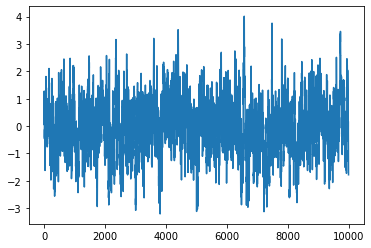

In [62]:
plt.plot(samples[num_burnin_steps:])

#### Rosenbrock function from follow "A STOCHASTIC NEWTON MCMC METHOD FOR LARGE-SCALE STATISTICAL INVERSE PROBLEMS WITH APPLICATION TO SEISMIC INVERSION"

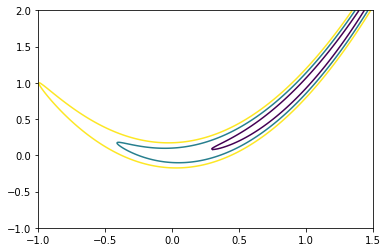

In [93]:
def rosenbrock(x,y):
      return (1-x)**2 + 100* ((y-x**2))**2

from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
import matplotlib.pyplot as plot
import numpy as np

# fig = plot.figure()
# ax = fig.gca(projection='3d')

s = 0.01  # Try s=1, 0.25, 0.1, or 0.05
X = np.arange(-1, 1.5+s, s)   #Could use linspace instead if dividing
Y = np.arange(-1, 2.+s, s)   #evenly instead of stepping...
    
#Create the mesh grid(s) for all X/Y combos.
X, Y = np.meshgrid(X, Y)

#Rosenbrock function w/ two parameters using numpy Arrays
Z = (1.-X)**2 + 100.*(Y-X*X)**2

# surf = ax.plot_surface(X, Y, Z, rstride=1, cstride=1, cmap=cm.coolwarm,
#          linewidth=0, antialiased=False)  #Try coolwarm vs jet

 
# ax.zaxis.set_major_locator(LinearLocator(10))
# ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))

# fig.colorbar(surf, shrink=0.5, aspect=5)

# #Displays the figure, handles user interface, returns when user closes window
# plot.show()


plt.contour(X,Y,Z,[0.5,2,4])

Try to plot the true density of banana distribution

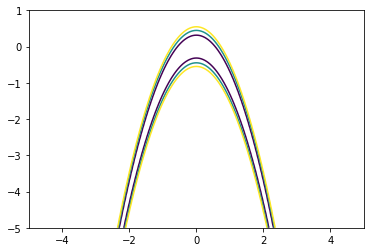

In [144]:
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
import matplotlib.pyplot as plot
import numpy as np

# fig = plot.figure()
# ax = fig.gca(projection='3d')

s = 0.05  # Try s=1, 0.25, 0.1, or 0.05
X = np.arange(-5, 5+s, s)   #Could use linspace instead if dividing
Y = np.arange(-5, 1.+s, s)   #evenly instead of stepping...
    
#Create the mesh grid(s) for all X/Y combos.
X, Y = np.meshgrid(X, Y)

Z =  (Y+X*X)**2

plt.contour(X,Y,Z,[0.1,0.2,0.3])

In [ ]:
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
import matplotlib.pyplot as plot
import numpy as np

# fig = plot.figure()
# ax = fig.gca(projection='3d')

s = 0.05  # Try s=1, 0.25, 0.1, or 0.05
X = np.arange(-5, 5+s, s)   #Could use linspace instead if dividing
Y = np.arange(-5, 1.+s, s)   #evenly instead of stepping...


    
#Create the mesh grid(s) for all X/Y combos.
X, Y = np.meshgrid(X, Y)

Z =  (Y+X*X)**2

plt.contour(X,Y,Z,[0.1,0.2,0.3])



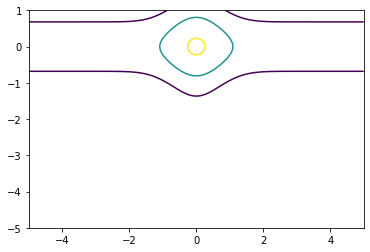

In [149]:
rv = norm(0,1)
x = rv.pdf(X)
y = rv.pdf(Y)

Z =  (y+x*x)**2

plt.contour(X,Y,Z,[0.1,0.2,0.3])

